### Objective: Solve u_t + (u(1-u))_x = 0 for x,t \in [0,1]x[0,tmax] using upwind numerical scheme. Use initial condition u_0= 0.5+0.3*cos(2*pi*x) and periodic boundary conditions. t_max = 0.5 (analytically, we know shock formation occurs at time t~0.27

#### let delta_x = 0.001, hence we have 1001 grid points, with x_0=0 and x_1000 = 1, and generally x_n = n*0.001

#### In order to satisfy CFL condition, delta_t = delta_x^2/10 = 0.0001 and therefore total time steps = 0.5/0.0001 = 5,000 with t_0 = 0, t_5000 = 0.5

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [92]:
#generating some random functions...




In [93]:
tmax=1.5  #set maximum time
delta_x = 0.001 #spacial discretization fidelity

N = int(1/delta_x)   # have N=1/delta_x space steps, 0,...,N
delta_t = delta_x/10 
M = int(tmax/delta_t) #M time steps

def f(u):
    return u*(np.ones_like(u)-u)

def upf(u):
    out = np.zeros_like(u)
    
    for i in range(len(u)-1):
        #print(i)
        if f(u[i+1]-f(u[i])/(u[i+1]-u[i])) >= 0:
            out[i] = f(u[i])
        else:
            out[i] = f(u[i+1])
            
            
    if f(u[0]-f(u[len(u)-1]))/(u[0]-u[len(u)-1]) >= 0:
        out[len(u)-1] = f(u[len(u)-1])
    else:
        out[len(u)-1] = f(u[0])
        
    return out

def upf2(u):
    out = np.zeros_like(u)
    
    for i in range(len(u)-1):
        ap = max(0,1-2*u[i+1], 1-2*u[i])
        am = min(0,1-2*u[i+1], 1-2*u[i])
        out[i] = (ap*f(u[i]) - am*f(u[i+1]))/(ap-am) + (u[i+1]-u[i])*(am*ap)/(ap-am)
    lap = max(0,1-2*u[0], 1-2*u[-1])
    lam = min(0,1-2*u[0], 1-2*u[-1])
    out[-1] = (lap*f(u[-1]) - lam*f(u[0]))/(lap-lam) + (u[0]-u[-1])*(lam*lap)/(lap-lam)
        
    return out

u_initial = np.empty(N+1) #holds initial data

xvals = np.linspace(0,1,N+1) #holds x-values of grid points

#u_initial = 0.3*np.sin(np.pi*xvals)+0.5

print(f'Using {N}, spacial grid points,  {M}, time steps')

Using 1000, spacial grid points,  15000, time steps


In [94]:
test = np.array([1,2,3,4])
upf2(test)
test[-1]

4

### Now we build the scheme by which u_n+1 is found from u_n.

[0.58703512 0.58677184 0.58650856 ... 0.587825   0.5875617  0.58729841]


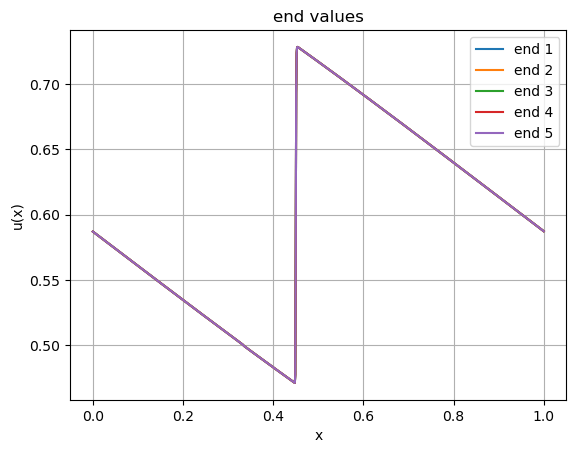

In [95]:


# Define the number of functions
num_functions = 5
Data = np.empty((num_functions,M,N+1))  #Data[i][j][k]
# Define the domain and range

y_min = 0.3
y_max = 0.7

# Generate random smooth functions for initial data
for i in range(num_functions):
    # Generate random control points
    control_points = np.random.uniform(y_min, y_max, 3)

    # Add the first point as the last point to enforce periodicity
    control_points = np.append(control_points, control_points[0])

    # Fit a smooth curve through the control points using a cubic spline
    from scipy.interpolate import CubicSpline
    cs = CubicSpline(np.linspace(0, 1, 4), control_points, bc_type='periodic')

    # Evaluate the curve on the given domain
    #y = cs(xvals)
    y= 0.2*np.cos(2*np.pi*xvals)+0.6

    u_hist = np.empty(shape=(M,N+1))  # u[i] stores approximate solution at time step i, or t=i*delta_t

    u_now = np.copy(y)  #store current solution
    
    u_hist[0] = u_now
    
    u_next = np.zeros_like(u_now) #will hold solution at next time step

    for tstep in range(1,M):

        forward_points = np.array([u_now[i] for i in range(1, len(u_now))] + [u_now[0]])  # [u(x_1), u(x_2),...,u(x_N),u(x_0)]

        backward_points = np.array([u_now[-1]] + [u_now[i] for i in range(0, len(u_now)-1)])  #[u(x_N),u(x_0), u(x_1),...,u(x_N-1)]
        #print(u_now,forward_points,backward_points)
        #u_next = u_now - (delta_t/(2*delta_x))*(forward_points-backward_points) #linear advection upwind
        #u_next = u_now-(delta_t/(2*delta_x))*(np.subtract(f(forward_points),f(backward_points))) #apply the scheme
        #u_next = u_now-(delta_t/(delta_x))*(np.subtract(f(forward_points),f(u_now))) #upwind...
        #u_next = u_now-(delta_t/delta_x)*(f(u_now)-f(backward_points)) #downwind...
        #u_next = u_now+(delta_t/delta_x)*(f(backward_points)-f(u_now))
        #u_next = (delta_t/2)*(forward_points+backward_points)-(1/(2*delta_x))*(f(forward_points)-f(backward_points))#Lax Friedrich
        u_next = u_now - (delta_t/delta_x)*(upf2(u_now)-upf2(backward_points))
        u_hist[tstep]=u_next #store soln at current time step

        u_now = u_next #move forward in time
    plt.plot(xvals, u_now, label=f'end {i + 1}')
    Data[i] = (u_hist)
    
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('end values')
plt.legend()
plt.grid(True)
print(u_now)
# Show the plot
#plt.show()

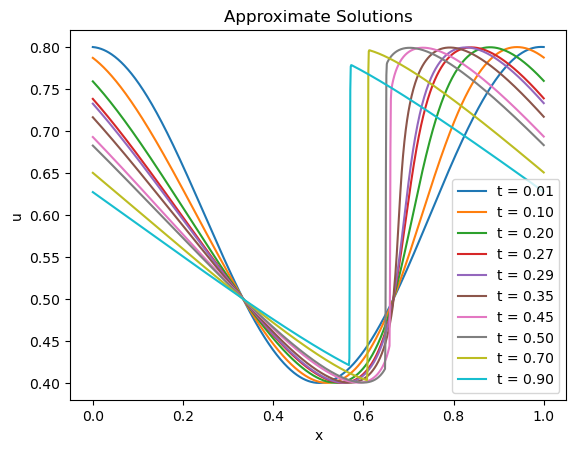

0.6271445119534905

In [96]:
# Specify the time steps at which you want to plot
time_steps = [0.01, 0.1,  0.2,0.27, 0.29,0.35,0.45,0.5,0.7,0.9]

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate through the specified time steps and plot the data
for t in time_steps:
    # Find the index corresponding to the closest time step in the uhist array
    tstep = int(t / delta_t)  # Assuming you have a time step size 'dt'

    # Plot the data at the current time step with label
    ax.plot(xvals, u_hist[tstep], label=f't = {t:.2f}')

# Add labels, legend, and other plot details
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.set_title('Approximate Solutions')
ax.legend()

# Show the plot
plt.show()
u_hist[tstep][0]

## We can see that the numerical solution blows up at t=0.27, as expected.

In [18]:
# Specify the file path where you want to save the CSV file
csv_file_path = "sinpi.csv"

# Open the CSV file in write mode
with open(csv_file_path, mode="w", newline="") as file:
    # Create a CSV writer object
    writer = csv.writer(file)

    # Write the data to the CSV file
    for row in u_hist:
        writer.writerow(row)

print(f"Data has been written to {csv_file_path}")

Data has been written to sinpi.csv
